In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
sys.path.append('/global/u2/t/tvnguyen/sbi_stream')
import pickle

import tarp
import corner
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import astropy.constants as const
import astropy.units as u
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

import datasets
from sbi.utils import BoxUniform
from sbi_stream import infer_utils
from sbi_stream.npe import NPE

%matplotlib inline
plt.style.use('default.mplstyle')

/global/homes/t/tvnguyen/.conda/envs/torch-py11/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [10]:
run_dir = '/pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/analysis_data/data'
run_files = [
    'uncertainty-nsf10/spline-6d-present.pkl',
    'uncertainty-nsf10/spline-2d-future.pkl',
    'uncertainty-nsf10/spline-6d-future.pkl',
    'uncertainty-nsf10/spline-6+2d-future.pkl',
]

all_samples = []
all_truths = []
all_log_probs = []

for run_file in run_files:
    save_file = os.path.join(run_dir, run_file)
    if not os.path.exists(save_file):
        print(f"File {save_file} does not exist. Skipping.")
        continue

    print(f"Loading from {save_file}")

    # Load the data
    with open(save_file, 'rb') as f:
        data = pickle.load(f)
    samples = data['samples']
    truths = data['truths']
    log_probs = data['log_probs']

    # correcting log probs
    prior_min = [-4, -1, -100, -100, 0, 0, ]
    prior_max = [-2, 0, 100, 100, 3, 360]
    prior_min = torch.tensor(prior_min, dtype=torch.float32)
    prior_max = torch.tensor(prior_max, dtype=torch.float32)
    prior = BoxUniform(
        low=prior_min, high=prior_max,
        device=torch.device('cpu'))
    prior_log_probs = prior.log_prob(torch.tensor(samples)).cpu().numpy()
    log_probs = log_probs + prior_log_probs

    # Store the data
    all_samples.append(samples)
    all_truths.append(truths)
    all_log_probs.append(log_probs)

Loading from /pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/analysis_data/data/uncertainty-nsf10/spline-6d-present.pkl
Loading from /pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/analysis_data/data/uncertainty-nsf10/spline-2d-future.pkl
Loading from /pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/analysis_data/data/uncertainty-nsf10/spline-6d-future.pkl
Loading from /pscratch/sd/t/tvnguyen/stream_sbi_shared/npe/analysis_data/data/uncertainty-nsf10/spline-6+2d-future.pkl


In [11]:
def compute_hpd_and_map(samples, log_probs, credible_level=0.95):
    # Convert log probabilities to probabilities
    probs = np.exp(log_probs)

    # Normalize probabilities to sum to 1
    probs = probs / np.sum(probs)

    # Find the MAP (maximum a posteriori)
    map_idx = np.argmax(probs)
    map_value = samples[map_idx]

    # Sort samples by probability (descending)
    sorted_indices = np.argsort(-probs)
    sorted_samples = samples[sorted_indices]
    sorted_probs = probs[sorted_indices]

    # Calculate cumulative probabilities
    cumulative_probs = np.nancumsum(sorted_probs)

    # Find all samples within the credible_level
    indices = np.where(cumulative_probs <= credible_level)[0]

    # print(indices)

    # If no samples fall exactly at the boundary, include one more
    if len(indices) < len(samples) and indices[-1] < len(sorted_samples) - 1:
        indices = np.append(indices, indices[-1] + 1)

    # Get the highest posterior density interval
    hpd_samples = sorted_samples[indices]

    # Find the lower and upper bounds
    hpd_lower = np.nanmin(hpd_samples)
    hpd_upper = np.nanmax(hpd_samples)

    return map_value, (hpd_lower, hpd_upper)

In [12]:
labels = [
    r'$\log {M_\mathrm{dm} / \mathrm{M_\odot}}$',
    r'$\log {r_\mathrm{dm} / \mathrm{kpc}}$',
    r'$V_\mathrm{z} \, [\mathrm{km/s}]$',
    r'$V_\mathrm{\phi} \, [\mathrm{km/s}]$',
    r'$b \, [\mathrm{kpc}]$',
    r'$\phi \, [\mathrm{deg}]$'
]

In [13]:
all_samples_map = []
all_samples_hpd = []
for samples, truths, log_probs in zip(
        all_samples, all_truths, all_log_probs):

    # use MAP to get predicted values
    samples_map = []
    samples_hpd = []
    for i in tqdm(range(len(samples))):
        map_val = []
        hpd_val = []
        for j in range(len(labels)):
            map_, hpd_ = compute_hpd_and_map(samples[i][..., j], log_probs[i], credible_level=0.68)
            map_val.append(map_)
            hpd_val.append(hpd_)
        samples_map.append(np.array(map_val))
        samples_hpd.append(np.array(hpd_val))
    all_samples_map.append(np.array(samples_map))
    all_samples_hpd.append(np.array(samples_hpd))

100%|██████████| 12799/12799 [00:06<00:00, 1917.67it/s]


### Plot predicted vs true

In [14]:
def predicted_vs_true(p, t, num_bins=10):
    '''calculate predicted vs true posterior,
    return bin_centers, median, error, standard deviation

    Parameters:
    ----------
    p: a list of predicted posteriors
    t: a list of true posteriors
    num_bins: number of bins on t
    '''
    bin_edges = np.linspace(t.min(), t.max(), num_bins+1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    p_median = np.zeros(num_bins)
    p_stdv = np.zeros(num_bins)
    p_count = np.zeros(num_bins)
    for i in range(num_bins):
        mask = (t >= bin_edges[i]) & (t <= bin_edges[i + 1])
        if mask.sum() <= 1:
            continue
        p_median[i] = p[mask].mean(axis=0)
        p_stdv[i] = p[mask].std(axis=0)
        p_count[i] = mask.sum()
    p_error = p_stdv / (p_count)**0.5
    return bin_centers, p_median, p_error, p_stdv

def predicted_vs_true_q(p, t, q, num_bins=10):
    '''calculate predicted vs true posterior,
    return bin_centers, median, error, standard deviation

    Parameters:
    ----------
    p: a list of predicted posteriors
    t: a list of true posteriors
    num_bins: number of bins on t
    '''
    bin_edges = np.linspace(t.min(), t.max(), num_bins+1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    p_q = np.zeros((num_bins, len(q)))
    for i in range(num_bins):
        mask = (t >= bin_edges[i]) & (t <= bin_edges[i + 1])
        if mask.sum() <= 1:
            continue
        p_q[i] = np.nanquantile(p[mask], q=q, axis=0).T

    return bin_centers, p_q

# plot predicted values (median) vs true values
def find_posterior_medians(posteriors):
     return [np.median(posterior) for posterior in posteriors]

In [15]:
all_xs = []
all_ys = []
for samples_map, truths in zip(all_samples_map, all_truths):
    xs = []
    ys = []
    for i in range(len(labels)):
        x, y = predicted_vs_true_q(samples_map[..., i], truths[..., i], q=[0.5, 0.16, 0.84], num_bins=15)
        xs.append(x)
        ys.append(y)
    all_xs.append(xs)
    all_ys.append(ys)

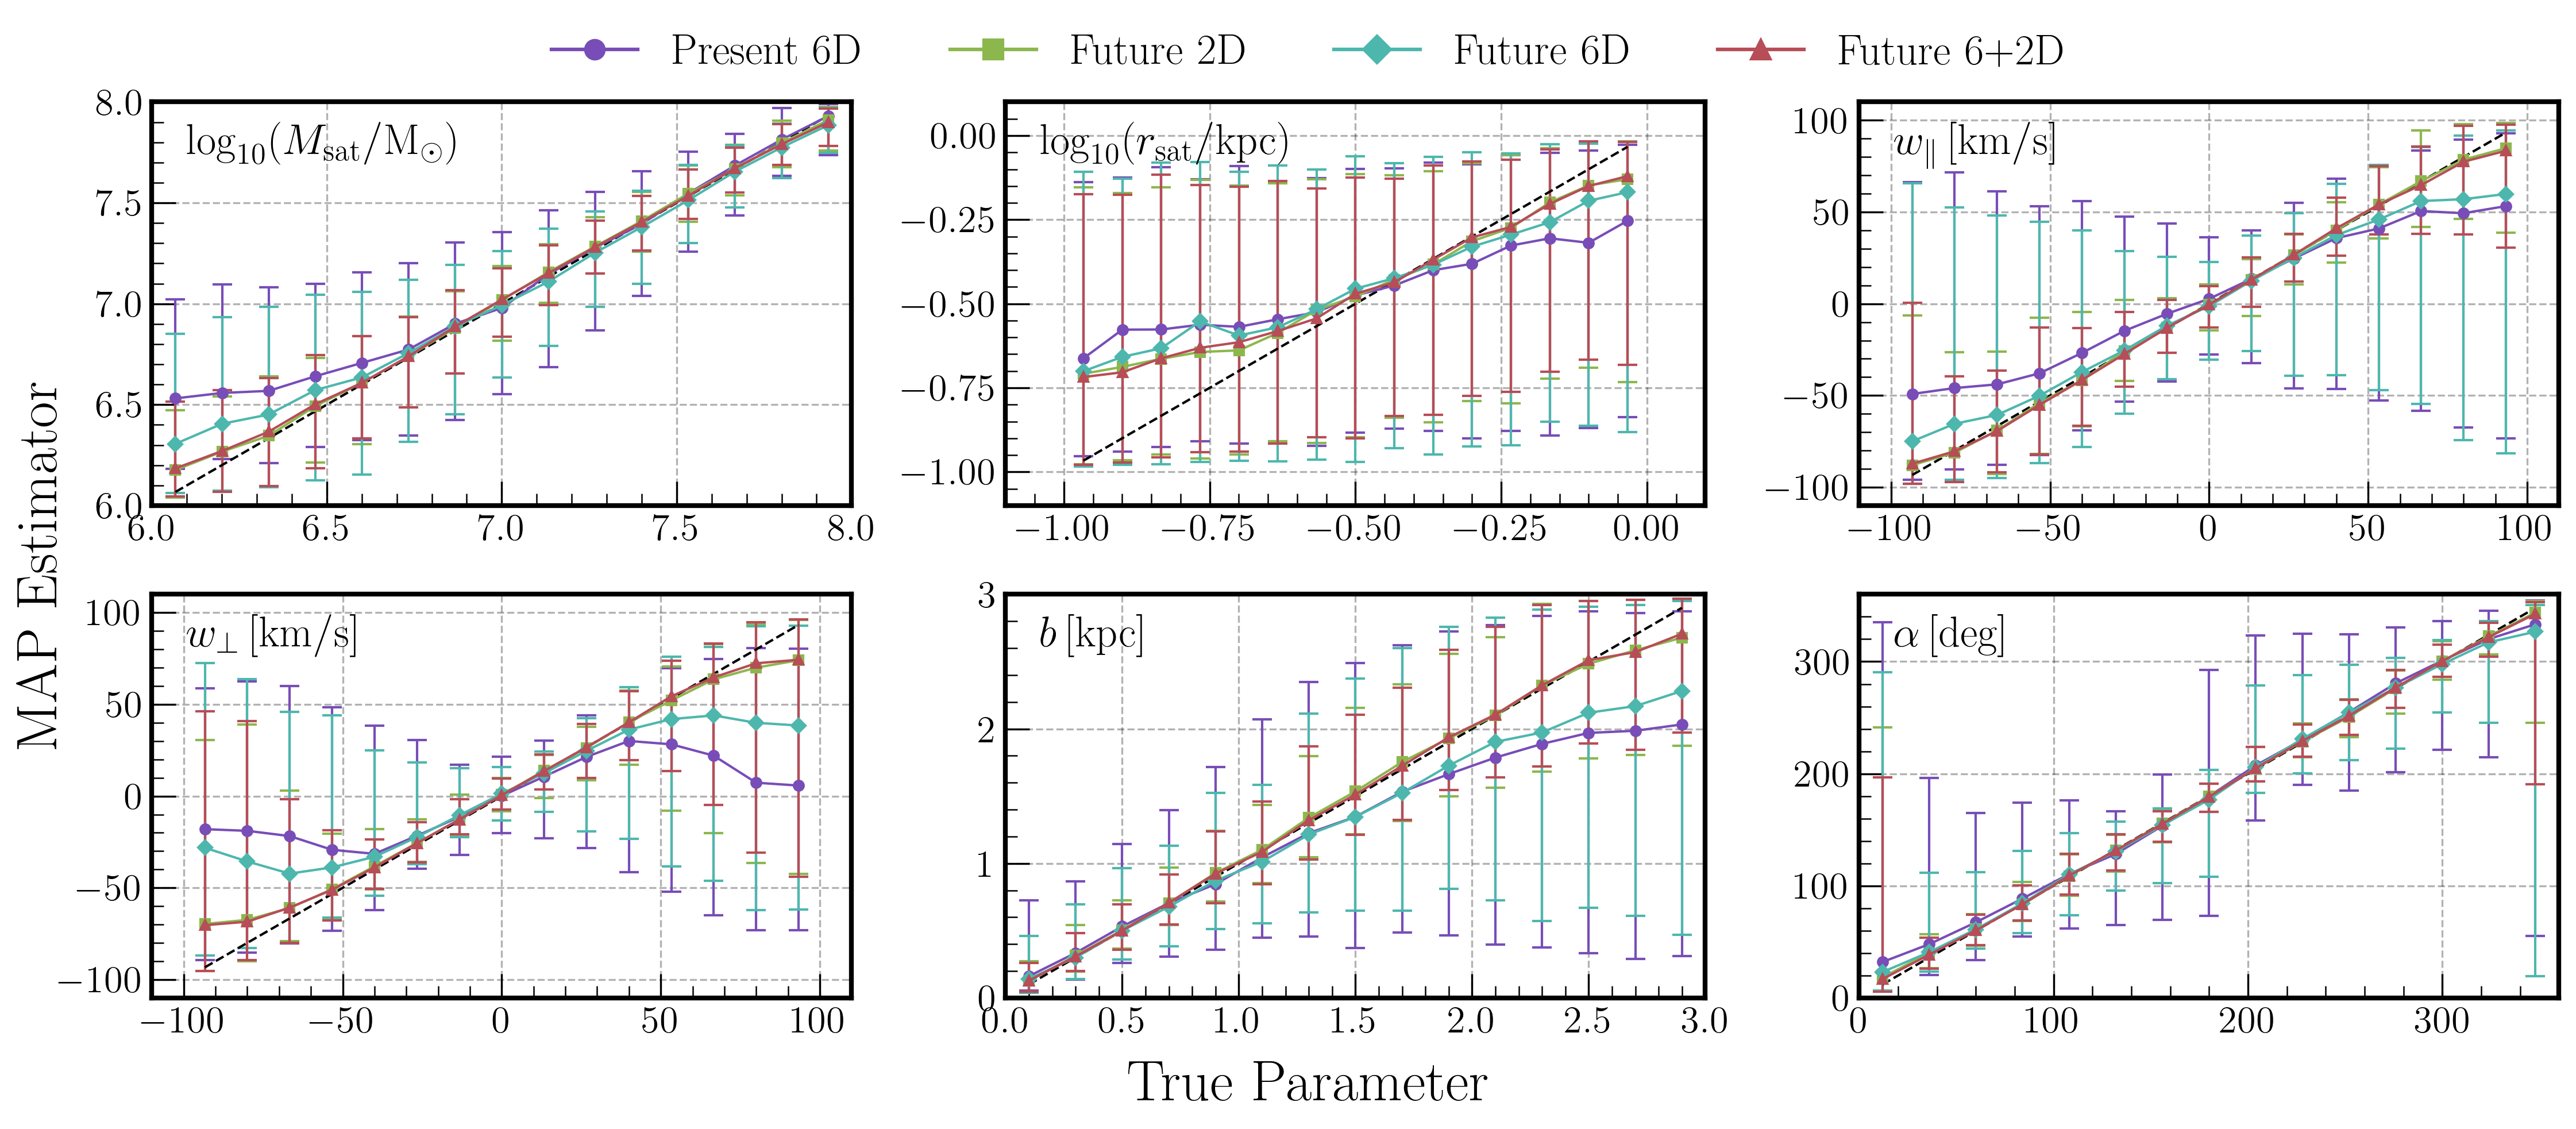

In [16]:
n_cols = 3
n_rows = 2
latex_labels = (
    r"$\log_{10} (M_\mathrm{sat} / \mathrm{M_\odot})$",
    r"$\log_{10} (r_\mathrm{sat} / \mathrm{kpc})$",
    r"$w_{\parallel} \, \mathrm{[km/s]}$",
    r"$w_{\perp} \, \mathrm{[km/s]}$",
    r"$b \, \mathrm{[kpc]}$",
    r"$\alpha \, \mathrm{[deg]}$"
)
run_labels = [
    'Present 6D',
    'Future 2D',
    'Future 6D',
    'Future 6+2D',
]
# colors = [
#     "C0",
#     "#840020",
#     "orangered",
# ]
colors = [
    "#784db7",
    "#8cb74d",
    "#4db7ad",
    "#b74d57"
]

# colors = sns.color_palette("colorblind", n_colors=n_rows * n_cols)
markers = ['o', 's', 'D', '^']

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows),
    dpi=300)

for i in range(n_rows * n_cols):
    ax = axes.ravel()[i]

    for j in range(len(all_xs)):
        x, yq = all_xs[j][i].copy(), all_ys[j][i].copy()
        xsc, ysc = samples_map[..., i].copy(), truths[..., i].copy()
        yerr = (yq[:, 0] - yq[:, 1], yq[:, 2] - yq[:, 0])

        if i == 0:
            x += 10
            yq += 10

        ax.errorbar(
            x, yq[..., 0], yerr=yerr, marker=markers[j], ls='-',
            capsize=4, markersize=4, lw=1, alpha=1,
            color=colors[j], label=run_labels[j])

    ax.plot(x, x, ls='--', color='k', lw=1)
    # Handle negative values for symmetric axis limits
    # x_min, x_max = x.min(), x.max()
    # buffer = 0.075 * (x_max - x_min)
    # ax.set_xlim(x_min - buffer, x_max + buffer)
    # ax.set_ylim(x_min - buffer, x_max + buffer)

    # Place label as text at the upper left corner
    ax.text(
        0.05, 0.95, latex_labels[i], fontsize=18,
        transform=ax.transAxes, ha='left', va='top', fontweight='bold'
    )

# Set one y-label centered for the left column, and one x-label centered for the bottom row
fig.text(0.02, 0.5, 'MAP Estimator', va='center', ha='right', rotation='vertical', fontsize=24, fontweight='bold')
fig.text(0.5, 0.02, 'True Parameter', ha='center', va='top', fontsize=24, fontweight='bold')

axes.ravel()[0].set_xlim(6, 8)
axes.ravel()[0].set_ylim(6, 8)
axes.ravel()[1].set_xlim(-1.1, 0.1)
axes.ravel()[1].set_ylim(-1.1, 0.1)
axes.ravel()[2].set_xlim(-110, 110)
axes.ravel()[2].set_ylim(-110, 110)
axes.ravel()[3].set_xlim(-110, 110)
axes.ravel()[3].set_ylim(-110, 110)
axes.ravel()[4].set_xlim(0, 3)
axes.ravel()[4].set_ylim(0, 3)
axes.ravel()[5].set_xlim(0, 360)
axes.ravel()[5].set_ylim(0, 360)

# Create a legend with run labels
handles = []
for j, run_label in enumerate(run_labels):
    handle = plt.Line2D([], [], marker=markers[j], color=colors[j], label=run_label,
                         markerfacecolor=colors[j], markersize=8, linestyle='-')
    handles.append(handle)
fig.legend(
    handles, run_labels, loc='upper center', ncol=len(run_labels),
    bbox_to_anchor=(0.5, 1.05), fontsize=18, frameon=False,
)

fig.tight_layout()
fig.subplots_adjust(wspace=0.22, hspace=0.22)
fig.savefig('figures/predicted_vs_true_err.pdf', bbox_inches='tight', dpi=300)